# M5 Data Preparation

This notebook helps with loading and transforming the M5 dataset into higher-level, aggregate time series. M5, by default, is provided as a set of 30,490 individual time series. These correspond to individual product sales figures at individual Walmart stores. These time series can be naturally aggregated according to a hierarchy: 

<img src="https://www.artefact.com//wp-content/uploads/2021/03/Image-1-.png"/>

As we can see, the 30,490 time series correspond to sales figures for 3049 individual products across 10 stores. The products each belong to one of three product categories (Hobbies, Foods, and Household), which can be further broken down into a total of 7 product subcategories. The 10 stores each belong to one of three states (California, Texas, and Wisconsin). 

Other information are also provided as part of the M5 dataset, including product sell prices and a calendar of important events (e.g. holidays, relevant dates for [nutrition assistance programs](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133614)).

The following code has been adapted from this [repository](https://github.com/matthiasanderer/m5-accuracy-competition) for the official 2nd place M5 solution.

## Load data

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, Callback
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAPE, MAE, MASE, RMSE
from pytorch_forecasting.metrics import NormalDistributionLoss

In [2]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
sell_price = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
train = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv').set_index('id')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

In [3]:
sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
train.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [6]:
sample_sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build aggregate dataset

In [7]:
# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % train.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, train[col].nunique()))

  unique forecasts: 30490
   N_unique item_id: 3049
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [8]:
%%time
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(train[ts_cols].sum()).transpose()
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]
all_sales

CPU times: user 181 ms, sys: 378 ms, total: 559 ms
Wall time: 551 ms


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


In [9]:
%%time
# 2. All products by state (3 series)
state_sales = train.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)
state_sales

CPU times: user 930 ms, sys: 1.21 s, total: 2.14 s
Wall time: 2.14 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
1,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
2,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879


In [10]:
%%time
# 3. All products by store (10 series)
store_sales = train.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)
store_sales

CPU times: user 893 ms, sys: 726 ms, total: 1.62 s
Wall time: 1.62 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
1,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
2,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
3,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
4,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
5,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217
6,TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,...,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974
7,WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,...,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054
8,WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,...,5317,7704,7586,5011,4628,4533,4628,4880,5213,5068
9,WI_3,4038,4198,3317,3211,2132,4590,4486,5991,4850,...,3987,5674,5894,3897,3306,3268,3398,4126,4519,4757


In [11]:
%%time
# 4. All products by category (3 series)
cat_sales = train.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)
cat_sales

CPU times: user 940 ms, sys: 673 ms, total: 1.61 s
Wall time: 1.61 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,...,30107,36576,41447,29158,26148,24790,24737,28136,33599,35967
1,HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,...,3871,4893,5016,3528,3629,3740,3475,4143,5333,5280
2,HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,...,10095,12839,13458,9676,9000,8566,8751,10273,12586,13091


In [12]:
%%time
# 5. All products by department (7 series)
dept_sales = train.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)
dept_sales

CPU times: user 933 ms, sys: 663 ms, total: 1.6 s
Wall time: 1.59 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,...,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
1,FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,...,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
2,FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,...,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
3,HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,...,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
4,HOBBIES_2,154,185,185,138,100,87,89,155,158,...,449,479,552,419,487,449,448,382,501,560
5,HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,...,7936,10042,10572,7609,6999,6641,6759,7974,9668,10165
6,HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,...,2159,2797,2886,2067,2001,1925,1992,2299,2918,2926


In [13]:
## TOP LEVEL aggregates + TOTAL
all_aggregates = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)
all_aggregates

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338
1,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
2,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
3,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879
4,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
5,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
6,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
7,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
8,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
9,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217


In [14]:
main_df = all_aggregates.set_index('id_str').T
main_df['date'] = calendar[['d', 'date']].set_index('d')['date']
main_df = main_df.set_index('date')
main_df.index = pd.DatetimeIndex(main_df.index)
main_df

id_str,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,...,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,23178,3764,5689,2343,4094,16741,3610,154,4105,1584
2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,22758,3357,5634,2216,4209,16333,3172,185,3858,1776
2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,17174,2682,3927,1657,3174,12343,2497,185,2827,1100
2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,18878,2669,3865,1508,3606,13764,2531,138,2732,1133
2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,14603,1814,2729,1209,2869,10525,1714,100,1802,927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,37096,15678,10375,11043,3995,3789,5375,2519,3147,3518,...,24790,3740,8566,3073,4648,17069,3291,449,6641,1925
2016-05-19,36963,16297,9162,11504,4136,4037,5580,2544,2748,3126,...,24737,3475,8751,3251,4551,16935,3027,448,6759,1992
2016-05-20,42552,17430,12303,12819,4433,4751,5542,2704,3664,4249,...,28136,4143,10273,3735,4815,19586,3761,382,7974,2299


## Data Splitting

We immediately split the data into training and test sets. We can later split the training set into training and validation.

In [15]:
train_size = 0.8

train_df = main_df.iloc[:int(len(main_df)*train_size)]
test_df = main_df.iloc[int(len(main_df)*train_size):]

## Data Formatting

PyTorch Forecasting expects data to be formatted using its own [TimeSeriesDataSet](https://pytorch-forecasting.readthedocs.io/en/latest/data.html) objects. Building a TimeSeriesDataSet begins with a Pandas DataFrame, and like with Prophet and NeuralProphet, we need to add certain custom columns.

For this demo, we are once again specifying a lead time of 30 days and we will withhold the last 20% of data for testing. In the code below, we are very careful to ensure that when training and validating the model, it does not have access to the withheld data.

## Time Series Data Formatting

PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/data.html), a combination of `group_id` and `time_idx` identify a sample in the data, and that *if we have only one time series, to set* `group_id` *to a constant.*

`time_idx` is an *integer column denoting the time index*. This, as opposed to the `date` column, is used to determine the temporal sequence of samples. 

In [19]:

lag_time = 5*12
lead_time = 12
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [20]:
train_df

id_str,time_idx,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,...,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,group_ids
0,0,2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,...,3764,5689,2343,4094,16741,3610,154,4105,1584,0
1,1,2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,...,3357,5634,2216,4209,16333,3172,185,3858,1776,0
2,2,2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,...,2682,3927,1657,3174,12343,2497,185,2827,1100,0
3,3,2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,...,2669,3865,1508,3606,13764,2531,138,2732,1133,0
4,4,2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,...,1814,2729,1209,2869,10525,1714,100,1802,927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,1547,2015-04-25,43598,19071,12049,12478,6019,3230,7251,2571,...,4519,11531,3272,4967,19309,3991,528,9152,2379,0
1548,1548,2015-04-26,43406,19426,12387,11593,5815,2947,7890,2774,...,4463,10800,3220,4987,19936,3980,483,8480,2320,0
1549,1549,2015-04-27,33444,14773,9873,8798,3995,2257,5909,2612,...,3412,7923,2683,4303,15123,3045,367,6253,1670,0
1550,1550,2015-04-28,29750,13044,8805,7901,3526,1930,5420,2168,...,3098,7276,2474,3608,13294,2792,306,5678,1598,0


## Preparing a TimeSeriesDataSet for N-BEATS

N-BEATS is a univariate forecasting method. As such, it can only process one variable at a time.

In [84]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'date'], value_vars=main_df.columns, var_name='group_ids')
train_df_nbeats['value'] = train_df_nbeats['value'].astype('float64')
train_df_nbeats.head()

,time_idx,date,group_ids,value
0,0,2011-01-29,all,32631.0
1,1,2011-01-30,all,31749.0
2,2,2011-01-31,all,23783.0
3,3,2011-02-01,all,25412.0
4,4,2011-02-02,all,19146.0


In [85]:
train_df_nbeats.tail()

,time_idx,date,group_ids,value
37243,1547,2015-04-25,HOUSEHOLD_2,2379.0
37244,1548,2015-04-26,HOUSEHOLD_2,2320.0
37245,1549,2015-04-27,HOUSEHOLD_2,1670.0
37246,1550,2015-04-28,HOUSEHOLD_2,1598.0
37247,1551,2015-04-29,HOUSEHOLD_2,1556.0


In [86]:
train_df_nbeats['value'] = train_df_nbeats['value'].astype('float64')

The following code defines the training/validation split and important parts of the prediction task - the lag time and lead time. Here we are specifying that 25% of the training data should be used for validation. In total, this results in a 60/20/20 train/valid/test split (since 25% of 80% is 20% of the initial 100%).

In [87]:
# define dataset
valid_size = 0.25  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
context_length = max_encoder_length
prediction_length = max_prediction_length

Since NBEATS is actually a univariate forecasting model, it makes sense that pytorch-forecasting does not support specifying explanatory variables as `time_varying_unknown_reals`. Earlier, we used the Pandas function `melt` to reshape the data into a single `value` column that is uniquely indexed by pairs of `(time_idx, group_ids)`.

In [88]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
)

In [90]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats,
                                            min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Training the model

In our first effort to train the N-BEATS model, we adopt the default configuration suggested by the pytorch-forecasting [tutorials](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/ar.html).

In [92]:
class EpochCallback(Callback):
        
    def on_validation_epoch_end(self, trainer, module):
        print(trainer.progress_bar_metrics)

In [93]:
pl.seed_everything(2022)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
epoch_callback = EpochCallback()

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback, epoch_callback],
    limit_train_batches=1.0,
)

net = NBeats.from_dataset(
    training,
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 2022
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  coefficients = torch.tensor([backcast_linspace ** i for i in range(thetas_dim)], dtype=torch.float32)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM h

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 2022


{'sanity_check_loss': 1.287200689315796}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 112. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


{'train_loss_step': 0.9409353733062744, 'val_loss': 0.8560143113136292}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.7462496161460876, 'val_loss': 0.683597207069397, 'train_loss_epoch': 1.0832635164260864}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.7192454934120178, 'val_loss': 0.6585376858711243, 'train_loss_epoch': 0.7908035516738892}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6581748723983765, 'val_loss': 0.649315595626831, 'train_loss_epoch': 0.7105822563171387}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6797361373901367, 'val_loss': 0.646203339099884, 'train_loss_epoch': 0.6934162378311157}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6635580062866211, 'val_loss': 0.6427282691001892, 'train_loss_epoch': 0.6849609017372131}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6657281517982483, 'val_loss': 0.6405494809150696, 'train_loss_epoch': 0.6780982613563538}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6933465600013733, 'val_loss': 0.6392356753349304, 'train_loss_epoch': 0.6730499863624573}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6286261677742004, 'val_loss': 0.6372367739677429, 'train_loss_epoch': 0.6686627864837646}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.664241373538971, 'val_loss': 0.6354885697364807, 'train_loss_epoch': 0.6643576622009277}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6495927572250366, 'val_loss': 0.6352720856666565, 'train_loss_epoch': 0.6607750654220581}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6204661726951599, 'val_loss': 0.6338882446289062, 'train_loss_epoch': 0.6567495465278625}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6552956700325012, 'val_loss': 0.6335199475288391, 'train_loss_epoch': 0.6536763310432434}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6421223282814026, 'val_loss': 0.6317657232284546, 'train_loss_epoch': 0.6512422561645508}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6435317993164062, 'val_loss': 0.6319624781608582, 'train_loss_epoch': 0.6475254893302917}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6869707107543945, 'val_loss': 0.6311711072921753, 'train_loss_epoch': 0.6446410417556763}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6485692858695984, 'val_loss': 0.6302182078361511, 'train_loss_epoch': 0.6418906450271606}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6454883217811584, 'val_loss': 0.6307958960533142, 'train_loss_epoch': 0.638992965221405}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6084243655204773, 'val_loss': 0.6295283436775208, 'train_loss_epoch': 0.6367238163948059}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6251575350761414, 'val_loss': 0.6296721696853638, 'train_loss_epoch': 0.6344166994094849}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6148012280464172, 'val_loss': 0.6295830011367798, 'train_loss_epoch': 0.631913959980011}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6202284693717957, 'val_loss': 0.6291749477386475, 'train_loss_epoch': 0.6300709247589111}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6439385414123535, 'val_loss': 0.6296851634979248, 'train_loss_epoch': 0.6278290748596191}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.646108865737915, 'val_loss': 0.6289610266685486, 'train_loss_epoch': 0.6255806684494019}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6089821457862854, 'val_loss': 0.6294307112693787, 'train_loss_epoch': 0.6234444975852966}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6380001902580261, 'val_loss': 0.629097044467926, 'train_loss_epoch': 0.6219269037246704}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6059256196022034, 'val_loss': 0.6289252638816833, 'train_loss_epoch': 0.6198104023933411}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6360959410667419, 'val_loss': 0.6298203468322754, 'train_loss_epoch': 0.6173068284988403}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.5972287058830261, 'val_loss': 0.6294260025024414, 'train_loss_epoch': 0.6160541772842407}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.604794442653656, 'val_loss': 0.6295711994171143, 'train_loss_epoch': 0.613885760307312}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6331110000610352, 'val_loss': 0.6288115978240967, 'train_loss_epoch': 0.612613320350647}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.5838974118232727, 'val_loss': 0.628933846950531, 'train_loss_epoch': 0.6106631755828857}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6342433094978333, 'val_loss': 0.6298075318336487, 'train_loss_epoch': 0.6092566251754761}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6285582184791565, 'val_loss': 0.62845778465271, 'train_loss_epoch': 0.6069529056549072}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6048237085342407, 'val_loss': 0.6297962665557861, 'train_loss_epoch': 0.6060019135475159}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.582076370716095, 'val_loss': 0.6296660900115967, 'train_loss_epoch': 0.6042676568031311}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.5746198296546936, 'val_loss': 0.6290728449821472, 'train_loss_epoch': 0.6024339199066162}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.597909688949585, 'val_loss': 0.6291748285293579, 'train_loss_epoch': 0.6018960475921631}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.6421056389808655, 'val_loss': 0.6294559240341187, 'train_loss_epoch': 0.599602222442627}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.63739413022995, 'val_loss': 0.629153311252594, 'train_loss_epoch': 0.5988890528678894}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.5502000451087952, 'val_loss': 0.6292550563812256, 'train_loss_epoch': 0.5966295003890991}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.568420946598053, 'val_loss': 0.629478394985199, 'train_loss_epoch': 0.5953083634376526}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.5643652081489563, 'val_loss': 0.6291446089744568, 'train_loss_epoch': 0.5937173366546631}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 0.5722923278808594, 'val_loss': 0.6294369697570801, 'train_loss_epoch': 0.5924785733222961}


In [103]:
test_df['all'] = test_df['all'].astype('float64')

## Testing the model


In [104]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="all",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["all"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

## Collect test set predictions

In [105]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
print(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

/ssd003/home/ssinha/forecasting-bootcamp/manulife_demo/lightning_logs/version_6739994/checkpoints/epoch=43-step=8975.ckpt


In [106]:
actuals

tensor([[33928., 32179., 38077.,  ..., 36049., 38210., 39895.],
        [32179., 38077., 41844.,  ..., 38210., 39895., 47405.],
        [38077., 41844., 54154.,  ..., 39895., 47405., 49594.],
        ...,
        [46400., 39379., 42248.,  ..., 37096., 36963., 42552.],
        [39379., 42248., 40503.,  ..., 36963., 42552., 51518.],
        [42248., 40503., 44073.,  ..., 42552., 51518., 54338.]])

In [107]:
predictions

tensor([[35154.1367, 32606.0957, 32750.8711,  ..., 35938.2617, 36921.0312,
         39971.5625],
        [32703.6816, 32553.3574, 36253.1016,  ..., 37150.4922, 41571.1641,
         45817.0469],
        [33249.4688, 35259.5391, 41134.4766,  ..., 42064.5859, 47422.8203,
         49332.3906],
        ...,
        [42600.0430, 38957.5273, 37331.2773,  ..., 34587.8164, 36336.0000,
         41207.2500],
        [40964.9688, 37549.7656, 39480.1289,  ..., 36997.2891, 42933.5625,
         48926.3906],
        [38971.3164, 39655.1484, 44890.2891,  ..., 42752.8633, 47611.4062,
         47963.7070]])

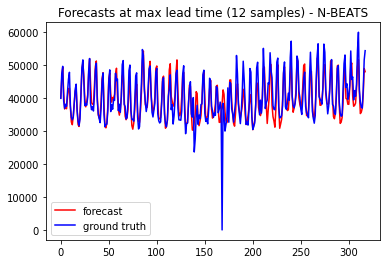

In [108]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

fig, ax = plt.subplots()
ax.plot(indexes, preds, color='red', label='forecast')
ax.plot(indexes, trues, color='blue', label='ground truth')
ax.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax.legend()

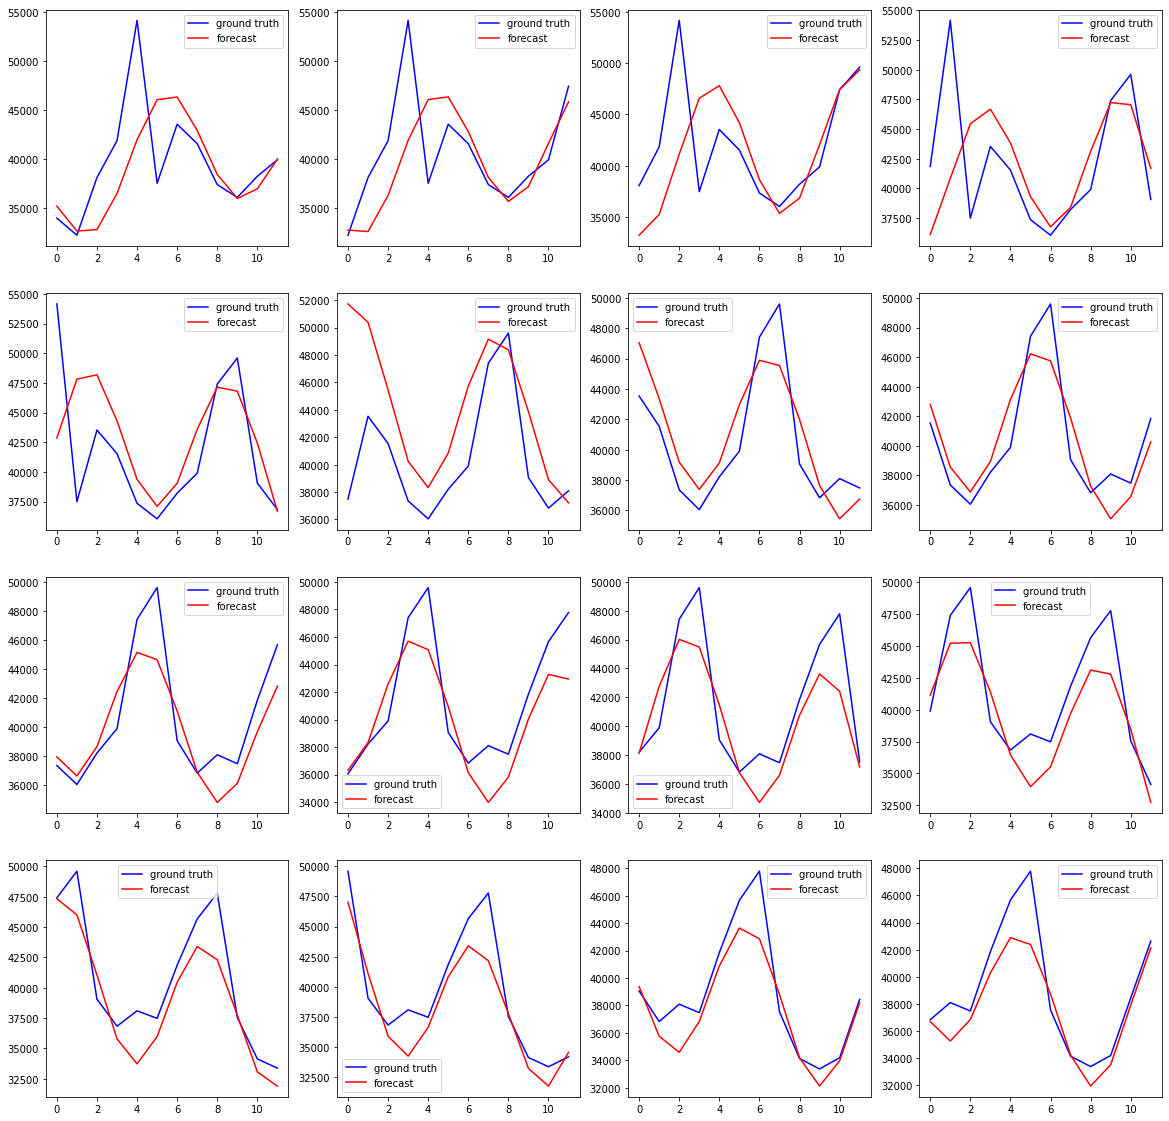

In [111]:
# plot at single time index

fig, axs = plt.subplots(4, 4, figsize=(20,20))
axs = axs.flatten()

for fig_index, example_index in enumerate(range(0, len(predictions_np), 1)):

    if fig_index > len(axs) - 1:
        break

    ground_truth = actuals_np[example_index]
    forecast = predictions_np[example_index]

    axs[fig_index].plot(list(range(0, len(forecast))), ground_truth, color='blue', label='ground truth')
    axs[fig_index].plot(list(range(0, len(forecast))), forecast, color='red', label='forecast')
    axs[fig_index].legend()

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

def compute_baseline_error_metrics(predictions, actuals):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(predictions)):
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=actuals[i], y_pred=predictions[i]))

    return errors

In [114]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

nbeats_errors = compute_baseline_error_metrics(predictions_np, actuals_np)
nbeats_stats = compute_error_statistics(nbeats_errors, 'nbeats')
nbeats_stats['mean']

mse     1.630338e+07
rmse    3.561192e+03
mae     2.692945e+03
mape    8.755153e+00
Name: nbeats_mean_metrics, dtype: float32